In [1]:
%pip install attractors Sparsemax

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from attractors import Attractor
from sklearn.cluster import KMeans
from sparsemax import Sparsemax

import optuna
import os
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sklearn
import imageio
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors

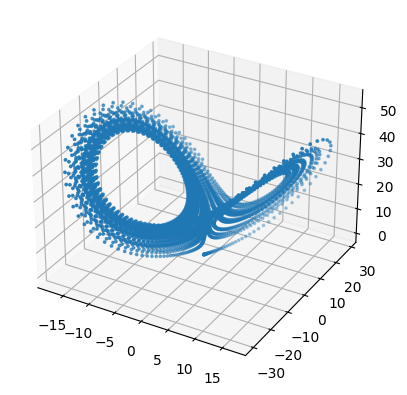

In [3]:
attr = Attractor("lorenz").rk4(0, 50, 5000)
df_lorenz = np.array([[i.X, i.Y, i.Z] for i in attr])
ax = plt.axes(projection="3d")
# ax.view_init(elev=20, azim=-70)
ax.scatter3D(df_lorenz.T[0], df_lorenz.T[1], df_lorenz.T[2], s=3)
plt.show()

In [4]:
class Dataset(Dataset):
   def __init__(self, data, targets=None):
       self.data = torch.from_numpy(data).float()

       self.targets = torch.from_numpy(targets).float() if targets is not None else None

   def __len__(self):
       return len(self.data)

   def __getitem__(self, idx):
       if self.targets is not None:
           return self.data[idx], self.targets[idx]
       else:
           return self.data[idx]

In [5]:
batch_size=256
lorenz_dataset = Dataset(df_lorenz)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
l_sz = 8

def get_encoder(d_input=3, d_latent=1, layer_sz=l_sz, alpha=1.0):
    encoder = nn.Sequential(
        nn.Linear(d_input, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_latent)
    )
    return encoder

def get_decoder(d_latent=1, d_output=3, layer_sz=l_sz, alpha=1.0):
    decoder = nn.Sequential(
        nn.Linear(d_latent, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, layer_sz),
        nn.BatchNorm1d(layer_sz),
        nn.ELU(alpha=alpha),
        nn.Linear(layer_sz, d_output)
    )
    return decoder

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=3, latent_dim=1, hidden_dim=64, gamma=0.1):
        super().__init__()
        
        self.encoder = get_encoder(3, 1, hidden_dim, gamma)
        
        self.decoder = get_decoder(1, 3, hidden_dim, gamma)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

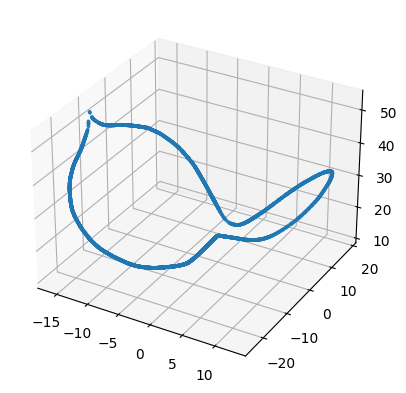

[I 2025-02-26 23:24:05,281] Trial 44 finished with value: 138.4387812614441 and parameters: {'hidden_dim': 256, 'learning_rate': 0.007226739781391062, 'weight_decay': 0.00016371557691850354, 'gamma': 0.1400184355934484, 'batch_size': 256}. Best is trial 41 with value: 124.17849016189575.
[I 2025-02-26 23:24:05,473] Trial 45 pruned. 



Trial 45
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.003589832391901955, 'weight_decay': 0.0009570412079196554, 'gamma': 0.22980728662451133, 'batch_size': 128}

Trial 46
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.005337156668570705, 'weight_decay': 0.0006550952212194115, 'gamma': 0.387442957489, 'batch_size': 256}


[I 2025-02-26 23:24:05,681] Trial 46 pruned. 
[I 2025-02-26 23:24:05,796] Trial 47 pruned. 



Trial 47
Current parameters: {'hidden_dim': 16, 'learning_rate': 0.001999690282021763, 'weight_decay': 0.00037983211585003077, 'gamma': 0.1756573631646343, 'batch_size': 256}

Trial 48
Current parameters: {'hidden_dim': 32, 'learning_rate': 0.007568783451290851, 'weight_decay': 0.0007173756059917263, 'gamma': 0.2571089982234076, 'batch_size': 256}


[I 2025-02-26 23:24:05,910] Trial 48 pruned. 



Trial 49
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.009863053555604386, 'weight_decay': 2.7627990165959782e-05, 'gamma': 0.30174067925905357, 'batch_size': 128}


[I 2025-02-26 23:24:06,448] Trial 49 pruned. 


Best trial:
  Value:  124.17849016189575
  Params: 
    hidden_dim: 256
    learning_rate: 0.0081791412492446
    weight_decay: 0.0006730701342390865
    gamma: 0.1691492402198212
    batch_size: 256


In [9]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'gamma': trial.suggest_float('gamma', 0.1, 3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256])
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    model = AutoEncoder(input_dim=3, latent_dim=1, hidden_dim=params['hidden_dim'], gamma=params['gamma']).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    criterion = nn.MSELoss()
    
    n_epochs = 1000
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step(total_loss)

        trial.report(total_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    recon = np.array(model(lorenz_dataset.data.to(device)).data.cpu())
    
    clear_output()

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)
    
    plt.show()

    return total_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = AutoEncoder(
    input_dim=3,
    latent_dim=1,
    hidden_dim=best_params['hidden_dim'],
    gamma=best_params['gamma']
).to(device)
best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

Loss: 112.40164375305176


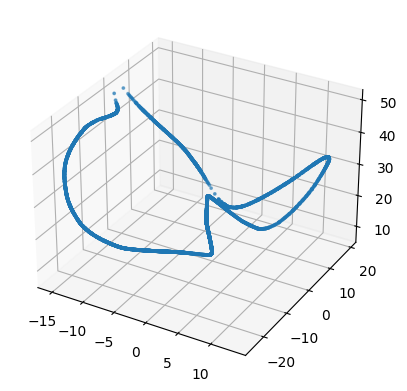

In [10]:
train_loader = DataLoader(
    lorenz_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    best_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

criterion = nn.MSELoss()

n_epochs = 1000
for epoch in range(n_epochs):
    best_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        reconstructed = best_model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        best_optimizer.step()
        total_loss += loss.item()

    scheduler.step(total_loss)

recon = np.array(best_model(lorenz_dataset.data.to(device)).data.cpu())

clear_output()

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3)

print(f'Loss: {total_loss}')
plt.show()

In [11]:
class ChartingAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, n_charts, alpha=1.0, gamma=1.0, beta=1.0):
        super().__init__()
        self.n_charts = n_charts
        self.gamma = gamma
        self.beta = beta
        self.encoders = nn.ModuleList([get_encoder(input_dim, latent_dim, hidden_dim, alpha) for _ in range(n_charts)])
        self.decoders = nn.ModuleList([get_decoder(latent_dim, input_dim, hidden_dim, alpha) for _ in range(n_charts)])
        self.proba = nn.Sequential(nn.Linear(input_dim, n_charts), Sparsemax(1))

    def recon_loss(self, x, z):
        x_recons = torch.stack([h_i(z[:, i]) for i, h_i in enumerate(self.decoders)], dim=1)
        
        recon_errors = torch.norm(x.unsqueeze(1) - x_recons, dim=-1)**2
        p = self.proba(x)
        loss = torch.mean(p * recon_errors)
        return loss, recon_errors

    def transition_loss(self, recon_errors, p):
        q = torch.softmax(-recon_errors, dim=-1)
        loss = -torch.sum(q * torch.log(p + 1e-8), dim=-1).mean()
        return loss

    def nondominance_loss(self, p):
        mean_p = p.mean(dim=0)
        target = torch.ones_like(mean_p) / self.n_charts
        loss = torch.sum((mean_p - target)**2)
        return loss
    
    def forward(self, x):
        z = torch.stack([g_i(x) for g_i in self.encoders], dim=1)
        p = self.proba(x)
        x_recons = torch.stack([h_i(z[:, i]) for i, h_i in enumerate(self.decoders)], dim=1)
        recon_x = torch.sum(x_recons * p.unsqueeze(-1), dim=1)
        
        recon_loss, recon_errors = self.recon_loss(x, z)
        trans_loss = self.transition_loss(recon_errors, p)
        nondom_loss = self.nondominance_loss(p)
        
        total_loss = recon_loss + self.gamma * trans_loss + self.beta * nondom_loss

        mse_loss = F.mse_loss(recon_x, x)
        
        return {
            'recon': recon_x,
            'latent': z,
            'probabilities': p,
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'nondom_loss': nondom_loss,
            'transition_loss': trans_loss,
            'mse_loss': mse_loss
        }

Epoch 1500/1500:
Total Loss: 4.9449
Recon Loss: 4.7108
Trans Loss: 0.0900
Nondom Loss: 0.0299
MSE Loss: 2.6382


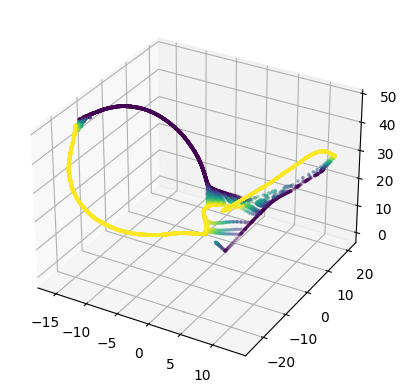

[I 2025-02-27 01:24:01,358] Trial 46 finished with value: 69.5311336517334 and parameters: {'hidden_dim': 256, 'learning_rate': 0.00404411964440752, 'weight_decay': 0.00034345132048201906, 'n_charts': 2, 'alpha': 4.055405181187816, 'gamma': 1.7145085780119, 'beta': 2.663726537847749, 'batch_size': 256}. Best is trial 46 with value: 69.5311336517334.



Trial 47
Current parameters: {'hidden_dim': 32, 'learning_rate': 0.0037585963533744685, 'weight_decay': 0.0003731391755271794, 'n_charts': 1, 'alpha': 4.110294353755252, 'gamma': 1.8199133726691925, 'beta': 2.8294848476529753, 'batch_size': 128}


[I 2025-02-27 01:24:01,691] Trial 47 pruned. 



Trial 48
Current parameters: {'hidden_dim': 16, 'learning_rate': 0.006020389877733175, 'weight_decay': 0.00029638815263930004, 'n_charts': 2, 'alpha': 4.555995168691082, 'gamma': 3.063681955933499, 'beta': 1.02512500959977, 'batch_size': 256}


[I 2025-02-27 01:24:01,977] Trial 48 pruned. 



Trial 49
Current parameters: {'hidden_dim': 256, 'learning_rate': 0.0030693241005086214, 'weight_decay': 0.0009165123724788563, 'n_charts': 2, 'alpha': 3.917739917182641, 'gamma': 1.5205314513295112, 'beta': 2.0958240654679576, 'batch_size': 64}


[I 2025-02-27 01:24:02,828] Trial 49 pruned. 


Best trial:
  Value:  69.5311336517334
  Params: 
    hidden_dim: 256
    learning_rate: 0.00404411964440752
    weight_decay: 0.00034345132048201906
    n_charts: 2
    alpha: 4.055405181187816
    gamma: 1.7145085780119
    beta: 2.663726537847749
    batch_size: 256


In [12]:
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [8, 16, 32, 64, 128, 256]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'n_charts': trial.suggest_int('n_charts', 1, 2),
        'alpha': trial.suggest_float('alpha', 0.05, 5.0),
        'gamma': trial.suggest_float('gamma', 1, 1000, log=True),
        'beta': trial.suggest_float('beta', 1, 1000, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256])
    }

    print(f"\nTrial {trial.number}")
    print(f"Current parameters:", trial.params)


    train_loader = DataLoader(
        lorenz_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    model = ChartingAE(
        input_dim=3,
        latent_dim=1,
        n_charts=params['n_charts'],
        hidden_dim=params['hidden_dim'],
        alpha=params['alpha'],
        gamma=params['gamma'],
        beta=params['beta']
    ).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )

    n_epochs = 1500
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            output['total_loss'].backward()
            optimizer.step()
            total_loss += output['mse_loss'].item()

        scheduler.step(total_loss)

        trial.report(total_loss, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()

    output = model(lorenz_dataset.data.to(device))
    recon = output['recon'].detach().cpu().numpy()
    probs = output['probabilities'].detach().cpu().numpy()

    clear_output()
    
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'Total Loss: {output["total_loss"].mean():.4f}')
    print(f'Recon Loss: {output["recon_loss"].mean():.4f}')
    print(f'Trans Loss: {output["transition_loss"].mean():.4f}')
    print(f'Nondom Loss: {output["nondom_loss"].mean():.4f}')
    print(f'MSE Loss: {output["mse_loss"].mean():.4f}')

    ax = plt.axes(projection="3d")
    ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3, c=probs[:, 0])
    
    plt.show()

    return total_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

best_params = study.best_trial.params
best_model = ChartingAE(
    input_dim=3,
    latent_dim=1,
    n_charts=best_params['n_charts'],
    hidden_dim=best_params['hidden_dim'],
    alpha=best_params['alpha'],
    gamma=best_params['gamma'],
    beta=best_params['beta']
).to(device)

best_optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

Epoch 5000/5000:
Total Loss: 6.4105
Recon Loss: 6.2937
Trans Loss: 0.0468
Nondom Loss: 0.0137
MSE Loss: 3.9399


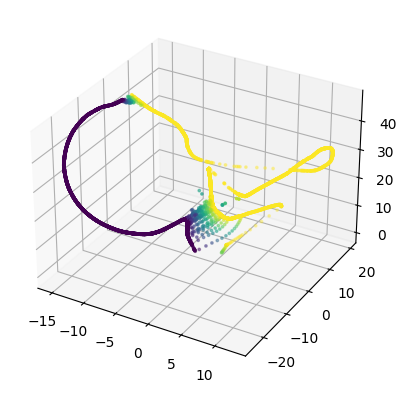

In [13]:
train_loader = DataLoader(
    lorenz_dataset,
    batch_size=256,
    shuffle=True
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    best_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

n_epochs = 5000
for epoch in range(n_epochs):
    best_model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        best_optimizer.zero_grad()
        output = best_model(batch)
        output['total_loss'].backward()
        best_optimizer.step()
        total_loss += output['total_loss'].item()

    scheduler.step(total_loss)


output = best_model(lorenz_dataset.data.to(device))
recon = output['recon'].detach().cpu().numpy()
probs = output['probabilities'].detach().cpu().numpy()

clear_output()

print(f'Epoch {epoch+1}/{n_epochs}:')
print(f'Total Loss: {output["total_loss"].mean():.4f}')
print(f'Recon Loss: {output["recon_loss"].mean():.4f}')
print(f'Trans Loss: {output["transition_loss"].mean():.4f}')
print(f'Nondom Loss: {output["nondom_loss"].mean():.4f}')
print(f'MSE Loss: {output["mse_loss"].mean():.4f}')

ax = plt.axes(projection="3d")
ax.scatter3D(recon[:, 0], recon[:, 1], recon[:, 2], s=3, c=probs[:, 0])

plt.show()